# Estimated Time of Arrival of Vessels - Exploratory Data Analysis and Machine Learning Models

### Importing Necessary Libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

### Reading the Excel File into a Dataframe

In [59]:
FILE = "ML Verileri.xlsx"
SHEET = "ETA"

df = pd.read_excel(FILE, sheet_name=SHEET)

In [60]:
df.head()

,FROM,TO,DONEM,ETD,ETA,PORT YOGUNLUGU,HAVA SARTLARI
0,TRYUM,TRMER,October,2023-10-19,2023-10-21,50,Rainy
1,EGPSD,TRKMX,February,2024-02-03,2024-02-07,20,Normal
2,EGALY,TRKCO,June,2025-06-20,2025-06-23,0,Windy
3,TRMER,ITSAL,August,2023-08-11,2023-08-16,30,Windy
4,TRBLD,TRALI,March,2025-03-28,2025-03-30,90,Normal


In [61]:

rename_map = {c: c.strip().upper().replace(" ", "_") for c in df.columns}
df.rename(columns=rename_map, inplace=True)

In [62]:
df.head()

,FROM,TO,DONEM,ETD,ETA,PORT_YOGUNLUGU,HAVA_SARTLARI
0,TRYUM,TRMER,October,2023-10-19,2023-10-21,50,Rainy
1,EGPSD,TRKMX,February,2024-02-03,2024-02-07,20,Normal
2,EGALY,TRKCO,June,2025-06-20,2025-06-23,0,Windy
3,TRMER,ITSAL,August,2023-08-11,2023-08-16,30,Windy
4,TRBLD,TRALI,March,2025-03-28,2025-03-30,90,Normal


### Transforming ETD and ETA date values to datetime datatype

In [63]:
df["ETD"] = pd.to_datetime(df["ETD"], errors="coerce")
df["ETA"] = pd.to_datetime(df["ETA"], errors="coerce")

### Creating a target transit duration as an integer

In [64]:
df["TRANSIT_DAYS"] = (df["ETA"] - df["ETD"]).dt.days.astype(int)

In [65]:
df.head()

,FROM,TO,DONEM,ETD,ETA,PORT_YOGUNLUGU,HAVA_SARTLARI,TRANSIT_DAYS
0,TRYUM,TRMER,October,2023-10-19,2023-10-21,50,Rainy,2
1,EGPSD,TRKMX,February,2024-02-03,2024-02-07,20,Normal,4
2,EGALY,TRKCO,June,2025-06-20,2025-06-23,0,Windy,3
3,TRMER,ITSAL,August,2023-08-11,2023-08-16,30,Windy,5
4,TRBLD,TRALI,March,2025-03-28,2025-03-30,90,Normal,2


## Exploratory Data Analysis

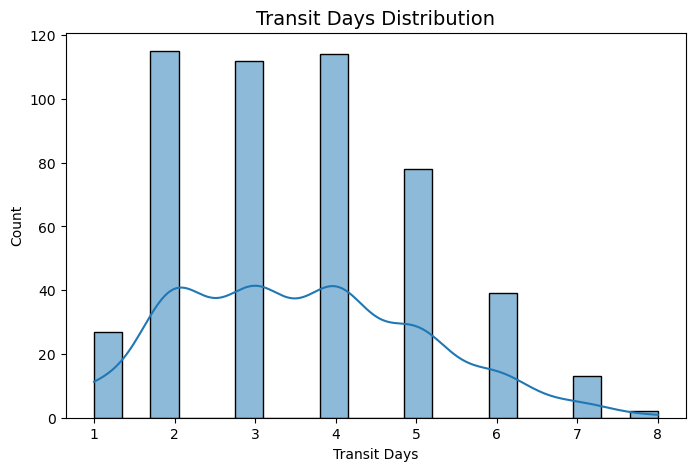

In [71]:
import seaborn as sns

# 1. Transit days distribution
plt.figure(figsize=(8,5))
sns.histplot(df["TRANSIT_DAYS"], bins=20, kde=True)
plt.title("Transit Days Distribution", fontsize=14)
plt.xlabel("Transit Days")
plt.ylabel("Count")
plt.show()

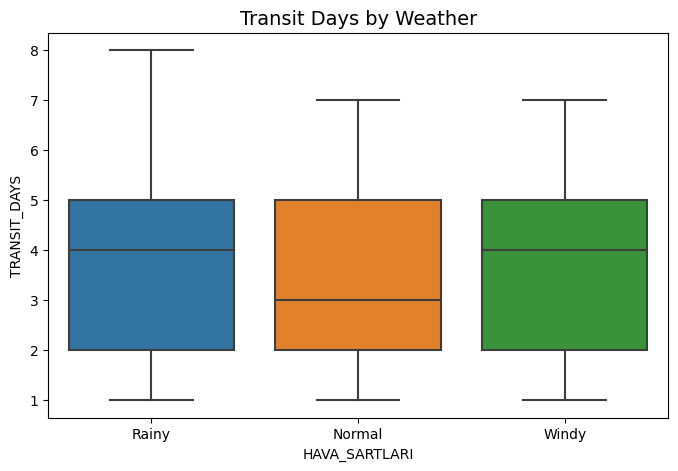

In [72]:
# 2. Boxplot by Weather
plt.figure(figsize=(8,5))
sns.boxplot(x="HAVA_SARTLARI", y="TRANSIT_DAYS", data=df)
plt.title("Transit Days by Weather", fontsize=14)
plt.show()

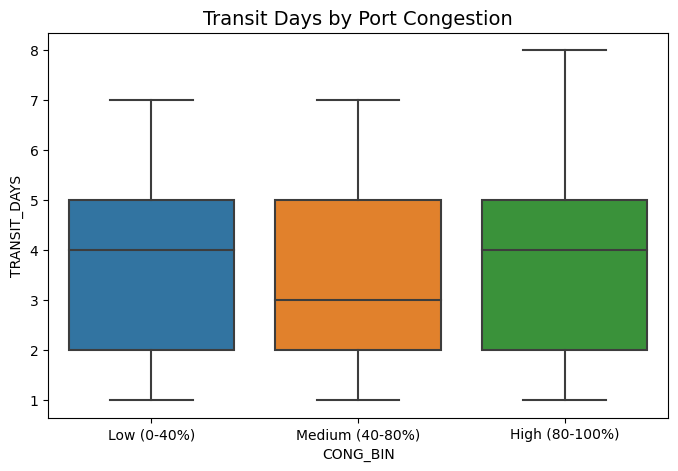

In [73]:
# 3. Boxplot by Port Congestion (binned)
df["CONG_BIN"] = pd.cut(df["PORT_YOGUNLUGU"], bins=[0,40,80,100], 
                        labels=["Low (0-40%)","Medium (40-80%)","High (80-100%)"])
plt.figure(figsize=(8,5))
sns.boxplot(x="CONG_BIN", y="TRANSIT_DAYS", data=df)
plt.title("Transit Days by Port Congestion", fontsize=14)
plt.show()

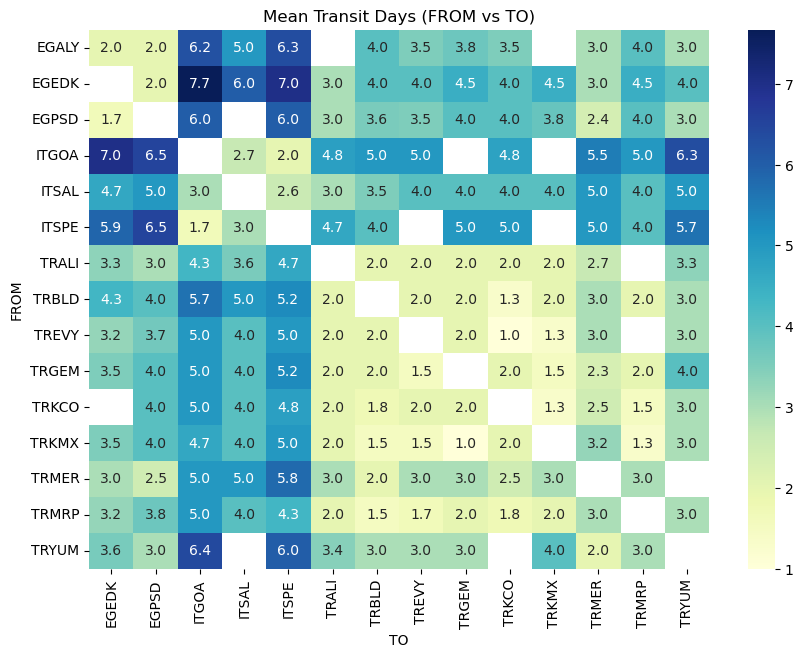

In [74]:
# 4. Heatmap of mean transit days by FROM/TO
pivot = df.pivot_table(index="FROM", columns="TO", values="TRANSIT_DAYS", aggfunc="mean")
plt.figure(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Mean Transit Days (FROM vs TO)")
plt.show()

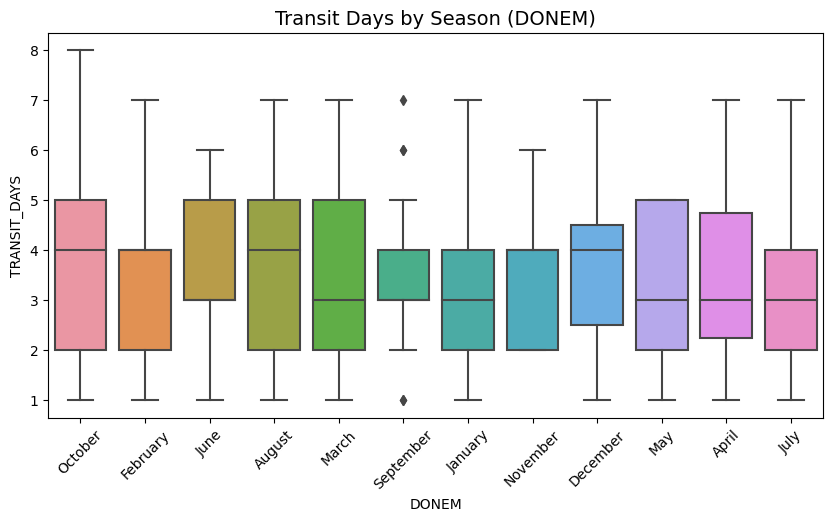

In [75]:
# 5. Seasonal trends (by DONEM)
plt.figure(figsize=(10,5))
sns.boxplot(x="DONEM", y="TRANSIT_DAYS", data=df)
plt.title("Transit Days by Season (DONEM)", fontsize=14)
plt.xticks(rotation=45)
plt.show()


### Dividing input variables and output variable ETA

In [66]:
X = df[["FROM","TO","DONEM","HAVA_SARTLARI","PORT_YOGUNLUGU","ETD"]].copy()
y = df["TRANSIT_DAYS"].astype(float)

### Add time features from ETD, then drop raw ETD

In [67]:
X["ETD_DOW"] = X["ETD"].dt.dayofweek
X["ETD_DOY"] = X["ETD"].dt.dayofyear
X.drop(columns=["ETD"], inplace=True)

## Machine Learning Implementation

RandomForest: MAE=0.52, RMSE=0.73, R2=0.730, ±1day%=87.0
HistGB: MAE=0.68, RMSE=0.95, R2=0.543, ±1day%=81.0

=== Model Comparison ===
RandomForest {'MAE': 0.5165045625901875, 'RMSE': 0.7274776426467725, 'R2': 0.7296982887017185, '±1day%': 87.0}
HistGB {'MAE': 0.6796245145858557, 'RMSE': 0.9458170413439908, 'R2': 0.5430972594633532, '±1day%': 81.0}

Best model: RandomForest

Top features (RandomForest Feature Importances):
 TO_ITGOA                0.118170
TO_ITSPE                0.117635
FROM_ITSPE              0.112166
FROM_ITGOA              0.109262
FROM_ITSAL              0.085510
TO_ITSAL                0.079303
ETD_DOY                 0.052100
PORT_YOGUNLUGU          0.036976
FROM_EGEDK              0.030212
ETD_DOW                 0.028355
TO_EGEDK                0.025286
TO_EGPSD                0.025066
FROM_EGALY              0.023120
FROM_EGPSD              0.022769
TO_TRYUM                0.016018
FROM_TRYUM              0.013336
TO_TRMER                0.012980
FROM_TRMER  

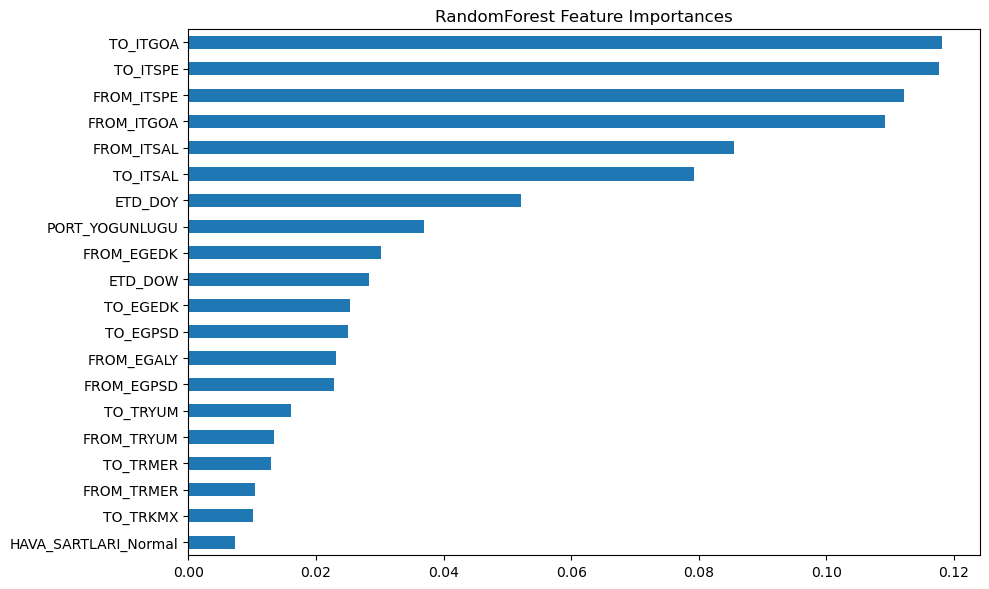

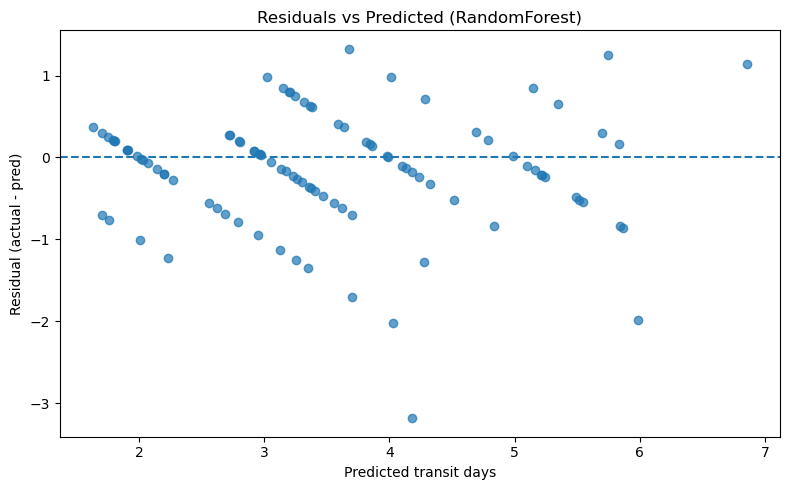

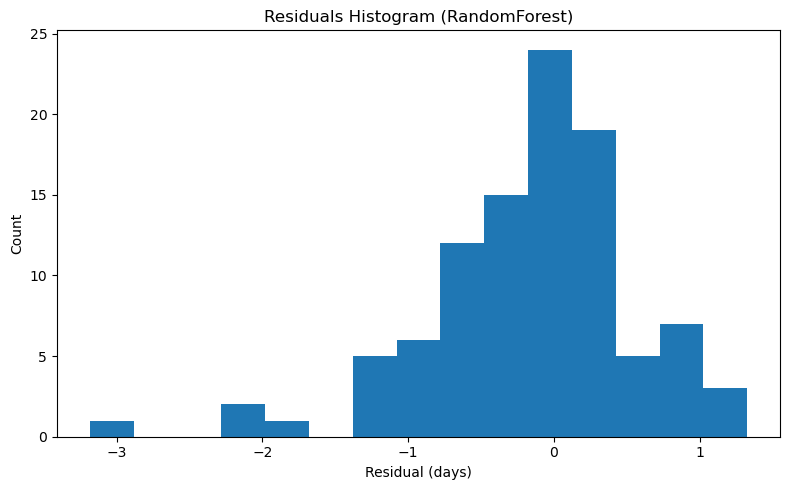


=== Overall (train+test ref) ===
MAE: 0.55 | RMSE: 0.80 | R2: 0.708 | ±1day%: 96.6
Saved: /Users/berilenbatan/eta_predictions.xlsx


In [69]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

numeric_features = ["PORT_YOGUNLUGU","ETD_DOW","ETD_DOY"]
categorical_features = ["FROM","TO","DONEM","HAVA_SARTLARI"]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # older sklearn

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", ohe, categorical_features)
    ],
    remainder="drop"
)

models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    ),
    "HistGB": HistGradientBoostingRegressor(
        max_iter=600, learning_rate=0.08, max_depth=None, random_state=42
    )
}

results = {}
fitted = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    hit1 = (np.abs(y_test - pred) <= 1).mean() * 100  # within ±1 day

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "±1day%": hit1}
    fitted[name] = pipe
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}, ±1day%={hit1:.1f}")

print("\n=== Model Comparison ===")
for k,v in results.items():
    print(k, v)

# Pick best by MAE
best_name = min(results, key=lambda k: results[k]["MAE"])
best_pipe = fitted[best_name]
print(f"\nBest model: {best_name}")

# -----------------------------
# -----------------------------
# 5) Feature importances (robust)
# -----------------------------
from sklearn.inspection import permutation_importance

prep = best_pipe.named_steps["pre"]
model = best_pipe.named_steps["model"]

# Recover feature names after preprocessing
ohe = prep.named_transformers_["cat"]
num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = num_names + cat_names

def plot_importances(series, title):
    top = series.sort_values(ascending=False).head(20)
    print(f"\nTop features ({title}):\n", top)
    plt.figure(figsize=(10,6))
    top.plot(kind="barh", title=title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Case A: model exposes impurity importances (e.g., RandomForest)
if hasattr(model, "feature_importances_"):
    importances = pd.Series(model.feature_importances_, index=feature_names)
    plot_importances(importances, f"{best_name} Feature Importances")

# Case B: no built-in importances (e.g., HistGB) -> permutation importance
else:
    # transform X_test through the same preprocessor
    Xte_pre = prep.transform(X_test)
    pi = permutation_importance(
        model, Xte_pre, y_test,
        n_repeats=20, random_state=42, scoring="neg_mean_absolute_error"
    )
    perm_series = pd.Series(pi.importances_mean, index=feature_names)
    plot_importances(perm_series, f"{best_name} Permutation Importances (MAE)")

    # (Optional) also fit a separate RandomForest JUST for interpretability,
    # using the same preprocessing; does not affect your chosen best model.
    rf_explainer = Pipeline(steps=[
        ("pre", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
            random_state=42, n_jobs=-1
        ))
    ])
    rf_explainer.fit(X_train, y_train)
    rf_m = rf_explainer.named_steps["model"]
    ohe_rf = rf_explainer.named_steps["pre"].named_transformers_["cat"]
    feat_names_rf = num_names + list(ohe_rf.get_feature_names_out(categorical_features))
    rf_importances = pd.Series(rf_m.feature_importances_, index=feat_names_rf)
    plot_importances(rf_importances, "RandomForest (explainer) Feature Importances")

# 6) Residual analysis (best model)
# -----------------------------
y_pred_test = best_pipe.predict(X_test)
resid = y_test - y_pred_test

plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, resid, alpha=0.7)
plt.axhline(0, ls="--")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.xlabel("Predicted transit days"); plt.ylabel("Residual (actual - pred)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(resid, bins=15)
plt.title(f"Residuals Histogram ({best_name})")
plt.xlabel("Residual (days)"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Predict on all rows & save
# -----------------------------
df_out = df.copy()
df_out["PRED_TRANSIT_DAYS"] = np.ceil(best_pipe.predict(X)).astype(int)
df_out["PRED_ETA"] = df_out["ETD"] + pd.to_timedelta(df_out["PRED_TRANSIT_DAYS"], unit="D")

# quick overall metrics on all rows (train+test for reference)
overall_mae = mean_absolute_error(df_out["TRANSIT_DAYS"], df_out["PRED_TRANSIT_DAYS"])
overall_rmse = math.sqrt(mean_squared_error(df_out["TRANSIT_DAYS"], df_out["PRED_TRANSIT_DAYS"]))
overall_r2 = r2_score(df_out["TRANSIT_DAYS"], df_out["PRED_TRANSIT_DAYS"])
overall_hit1 = (np.abs(df_out["TRANSIT_DAYS"] - df_out["PRED_TRANSIT_DAYS"]) <= 1).mean() * 100

print("\n=== Overall (train+test ref) ===")
print(f"MAE: {overall_mae:.2f} | RMSE: {overall_rmse:.2f} | R2: {overall_r2:.3f} | ±1day%: {overall_hit1:.1f}")

out_path = "eta_predictions.xlsx"
df_out[["FROM","TO","DONEM","ETD","ETA","TRANSIT_DAYS",
        "PORT_YOGUNLUGU","HAVA_SARTLARI",
        "PRED_TRANSIT_DAYS","PRED_ETA"]].to_excel(out_path, index=False)
print("Saved:", os.path.abspath(out_path))
